In [157]:
import itertools

import numpy as np
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [158]:
ft_train = np.load("./processed_data/features_train.npy")
ft_test = np.load("./processed_data/features_test.npy")
lbl_train = np.load("./processed_data/labels_train.npy")
lbl_test = np.load("./processed_data/labels_test.npy")

In [159]:
features = np.load("./processed_data/features.npy")
labels = np.load("./processed_data/labels.npy")

## Helper functions

In [160]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [161]:
def model_report_from(model, X_test, y_test, y_test_pred):
    if len(y_test_pred) != len(X_test):
        y_test_pred = model.predict(X_test)
        
    print(f"accuracy = {1 - sum(abs(y_test_pred - y_test))/len(y_test)}")
    print(f"precision = {precision_score(y_test, y_test_pred)}")
    print(f"recall = {recall_score(y_test, y_test_pred)}")
    print(f"f1 = {f1_score(y_test, y_test_pred)}")
    print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred)}")

    # display confusion matrix
    draw_confusion_matrix(y_test, y_test_pred, ["NO STROKE", "STROKE"])

    # draw ROC curve
    plot_roc_curve(model, X_test, y_test)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.ylabel("True Positive Rate (Recall)")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right")
    plt.show()



# Logistic Regression

## Hyperparameter tuning

In [162]:
param = {
    'C' : [0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5],
}
clf = GridSearchCV(LogisticRegression(class_weight='balanced'), param, scoring='f1', refit=True, cv=10)

In [163]:
clf.fit(ft_train, lbl_train)
clf.best_params_

{'C': 0.03}

## Training the model

In [164]:
lr = LogisticRegression(class_weight='balanced', C=clf.best_params_['C'])

In [165]:
lr.fit(ft_train, lbl_train)

LogisticRegression(C=0.03, class_weight='balanced')

## Results from the model

accuracy = 0.738747553816047
precision = 0.1245674740484429
recall = 0.72
f1 = 0.21238938053097345
ROC AUC score = 0.7298559670781893


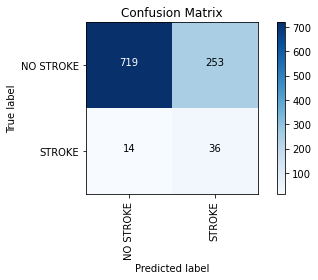

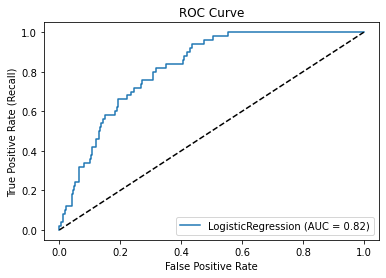

In [166]:
model_report_from(lr, ft_test, lbl_test, [])

## Taking a look at those that went wrong

In [167]:
df = pd.read_csv('./raw_data/dataset-stroke.csv').drop(columns=['id'])

In [168]:
df['pred_stroke'] = lr.predict(features)
df['prob_pos'] = lr.predict_proba(features)[:,1]

In [169]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,pred_stroke,prob_pos
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,1,0.832398
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,1,0.555917
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,1,0.797970
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,0,0.458548
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,1,0.869682


<ipython-input-170-882c6b908911>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.pred_stroke == 0][df.stroke == 1].hist(figsize=(20, 10))


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'hypertension'}>,
        <AxesSubplot:title={'center':'heart_disease'}>],
       [<AxesSubplot:title={'center':'avg_glucose_level'}>,
        <AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'stroke'}>],
       [<AxesSubplot:title={'center':'pred_stroke'}>,
        <AxesSubplot:title={'center':'prob_pos'}>, <AxesSubplot:>]],
      dtype=object)

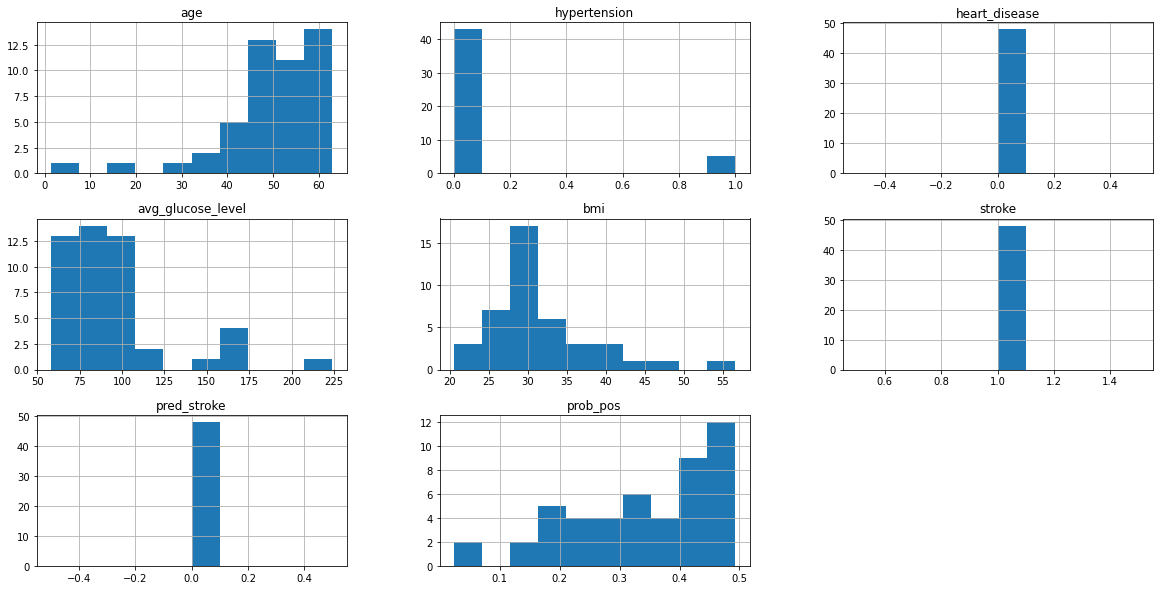

In [170]:
# False negatives (most dire)
df[df.pred_stroke == 0][df.stroke == 1].hist(figsize=(20, 10))

<ipython-input-171-078fa9df705f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.stroke==1][df.stroke == df.pred_stroke].hist(figsize=(20,10))


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'hypertension'}>,
        <AxesSubplot:title={'center':'heart_disease'}>],
       [<AxesSubplot:title={'center':'avg_glucose_level'}>,
        <AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'stroke'}>],
       [<AxesSubplot:title={'center':'pred_stroke'}>,
        <AxesSubplot:title={'center':'prob_pos'}>, <AxesSubplot:>]],
      dtype=object)

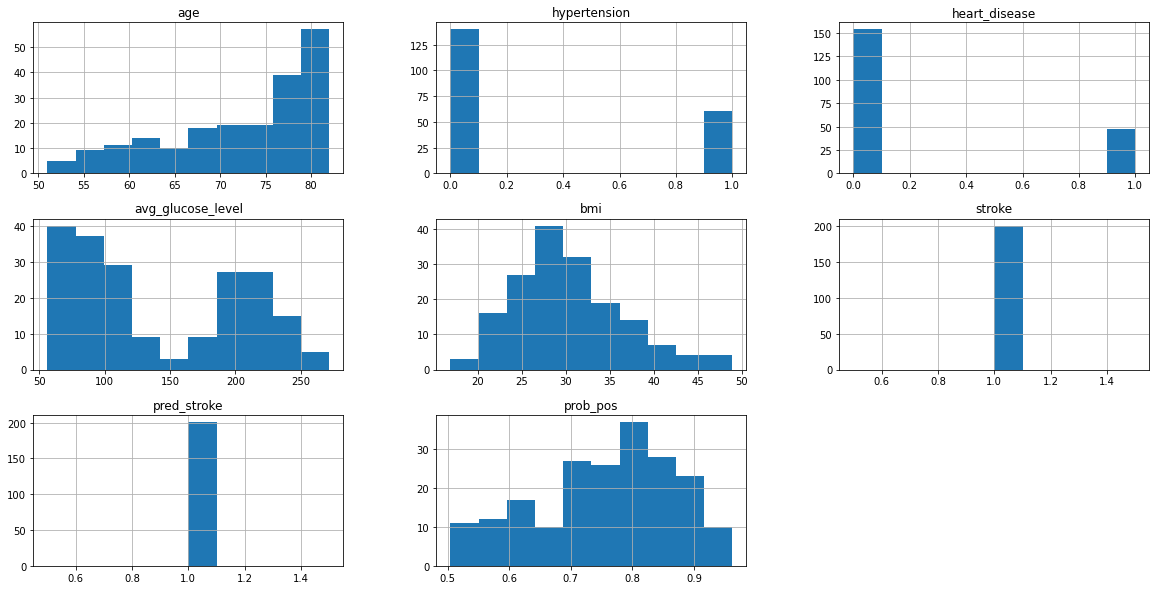

In [171]:
df[df.stroke==1][df.stroke == df.pred_stroke].hist(figsize=(20,10))

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'hypertension'}>,
        <AxesSubplot:title={'center':'heart_disease'}>],
       [<AxesSubplot:title={'center':'avg_glucose_level'}>,
        <AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'stroke'}>],
       [<AxesSubplot:title={'center':'pred_stroke'}>,
        <AxesSubplot:title={'center':'prob_pos'}>, <AxesSubplot:>]],
      dtype=object)

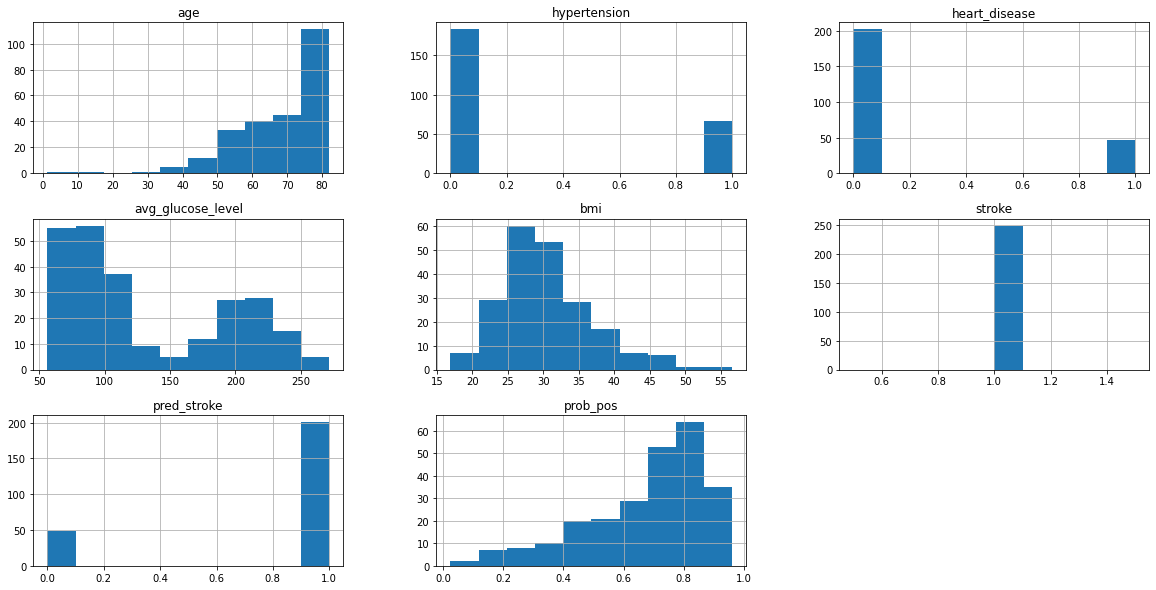

In [172]:
df[df.stroke == 1].hist(figsize=(20,10))

## Testing result of lowering probability threshold 

In [173]:
df['low_thresh_stroke'] = df.prob_pos.apply(lambda x: 1 if x > 0.35 else 0)

accuracy = 0.6295499021526418
precision = 0.10782442748091603
recall = 0.9076305220883534
f1 = 0.1927505330490405
ROC AUC score = 0.7614680073926646


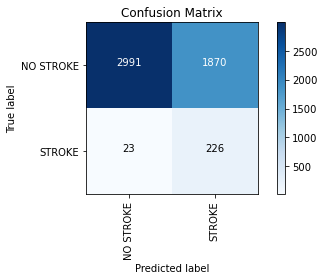

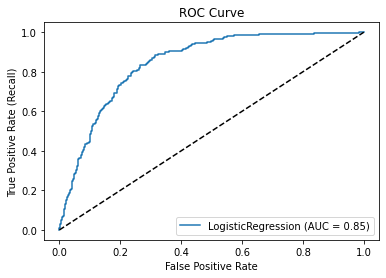

In [174]:
model_report_from(lr, features, labels, y_test_pred=df.low_thresh_stroke.to_numpy())

accuracy = 0.7469667318982387
precision = 0.13900414937759337
recall = 0.8072289156626506
f1 = 0.23716814159292038
ROC AUC score = 0.7755543878868695


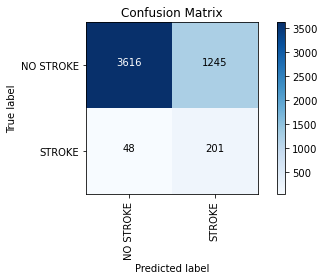

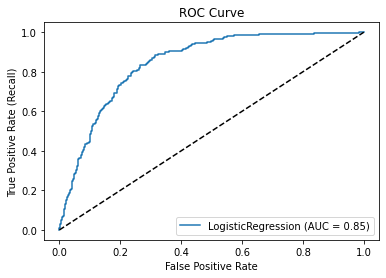

In [175]:
# vanilla (all data)
model_report_from(lr, features, labels, [])